<a href="https://colab.research.google.com/github/hkmamike/market-encoder/blob/main/model_baseline/market_encoder_model_vol_regression_baseline_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Install

In [1]:
!pip install awswrangler
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.4 MB/s eta 0:00:00


## Import

In [2]:
import pandas as pd
import awswrangler as wr
import boto3
import numpy as np
import matplotlib.pyplot as plt
from getpass import getpass
import os

In [3]:
import tensorflow as tf

In [4]:
from transformers import AutoTokenizer, TFBertModel, create_optimizer

# Set this environment variable regarding legacy keras to be safe
# Explanation: Transformers package uses Keras 2 objects, current version is Keras 3, packed in Tensorflow since version 2.16. Fastest fix without downgrading tensorflow is to set legacy keras usage flag as above. More info can be found here.
# https://stackoverflow.com/questions/79309854/valueerror-exception-encountered-when-calling-layer-tf-bert-model-type-tfber
os.environ["TF_USE_LEGACY_KERAS"] = "1"

# import legacy keras
import tf_keras
from tf_keras.layers import Dense, Input
from tf_keras.models import Model


In [5]:
print(tf_keras.__version__)
version_str = tf_keras.__version__
major_version = int(version_str.split('.')[0])

if major_version >= 3:
    raise ValueError(f"Keras version is {version_str}, which is 3.0 or higher. This setup requires Keras version < 3.0.")
else:
    print(f"Keras version {version_str} is compatible.")

2.19.0
Keras version 2.19.0 is compatible.


## Constants

In [26]:
# --- IMPORTANT: Set these variables before running ---
AWS_REGION = 'us-east-2'
S3_STAGING_DIR = 's3://cs230-market-data-2025/athena-query-results/'
ATHENA_DB = 'cs230_finance_data'
# Querying more data for a small training run
# MODIFIED: Select only concatarticles1 and vol_diff1 for baseline
SQL_QUERY = "SELECT concatarticles1, vol_diff1 FROM paired_vixy_w_titles_v3 WHERE vol_diff1 is not null ORDER BY RAND() LIMIT 10000"

LABEL_COLUMN = 'vol_diff1'
# Columns:
# concatarticles1: concatenated 10 titles (first of pair)
# vol_diff1: percet change of volatility between tomorrow open and yesterday close

# --- Model & Tokenizer Configuration ---
MODEL_NAME = "ProsusAI/finbert"
MAX_LENGTH = 256
VAL_RATIO = 0.2
# ----------------------------------------------------

## Connect AWS

In [7]:
# --- AWS Authentication for Colab ---
# Prompt for AWS credentials
aws_access_key_id = getpass('Enter AWS Access Key ID: ')
aws_secret_access_key = getpass('Enter AWS Secret Access Key: ')


Enter AWS Access Key ID: ··········
Enter AWS Secret Access Key: ··········


# Connect Google Drive


In [8]:
import os
from google.colab import drive
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M")

print("\n--- Mounting Google Drive ---")
# This will prompt you to authorize access to your Drive
drive.mount('/content/drive')

# Define base directory for saving models
BASE_DRIVE_PATH = '/content/drive/MyDrive/Colab Notebooks'
os.makedirs(BASE_DRIVE_PATH, exist_ok=True)

# Define specific paths for the two models
FULL_REGRESSION_SAVE_PATH = os.path.join(BASE_DRIVE_PATH, f'regression_model_{TIMESTAMP}.keras')


--- Mounting Google Drive ---
Mounted at /content/drive


## TPU config

In [9]:
# --- TPU Configuration ---
print("\n--- Step 2: Configuring TPU ---")
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print('Running on TPU ', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    # If TPU is not available, check for GPU.
    print('⚠️ TPU not found. Checking for GPUs.')
    if tf.config.list_physical_devices('GPU'):
        # If GPUs are available, MirroredStrategy will use them all.
        # If only one GPU is available, it will use that one.
        strategy = tf.distribute.MirroredStrategy()
        print(f'✅ Running on {len(tf.config.list_physical_devices("GPU"))} GPU(s).')
    else:
        # If no GPU is found, fall back to CPU
        print('⚠️ No GPUs found. Running on CPU.')
        strategy = tf.distribute.get_strategy() # Default strategy for CPU

print(f"REPLICAS: {strategy.num_replicas_in_sync}")



--- Step 2: Configuring TPU ---
⚠️ TPU not found. Checking for GPUs.
✅ Running on 1 GPU(s).
REPLICAS: 1


# Preprocessing

## Read data from aws

In [27]:


print(f"\n--- Step 3: Configuration set for {ATHENA_DB} ---")
print(f"--- Step 4: Querying Data ---")
print(f"Querying data from {ATHENA_DB}....")

# Define df in a wider scope
df = None

try:
    # Create a boto3 session with the provided credentials
    session = boto3.Session(
        aws_access_key_id=aws_access_key_id,
        aws_secret_access_key=aws_secret_access_key,
        region_name=AWS_REGION,
    )

    # Run the query and load results into a Pandas DataFrame
    df = wr.athena.read_sql_query(
        sql=SQL_QUERY,
        database=ATHENA_DB,
        s3_output=S3_STAGING_DIR,
        boto3_session=session,
    )

    print("\nQuery successful! Data loaded into DataFrame.")

    # Display the first 5 rows
    print(df.head())

except Exception as e:
    print(f"\nAn error occurred:")
    print(e)


--- Step 3: Configuration set for cs230_finance_data ---
--- Step 4: Querying Data ---
Querying data from cs230_finance_data....

Query successful! Data loaded into DataFrame.
                                     concatarticles1  vol_diff1
0  Wall Street Analysts Predict a 1249.93% Upside...  -0.639538
1  Energy/Materials - Top Gainers / Losers as of ...   2.931497
2  French court of appeal upholds Kerviel convict...   2.660677
3  C Spire Wireless ready for 2013 Atlantic hurri...   1.725888
4  Iranians play role in breaking IS siege of Ira...  -0.960512


## Tokenizer

In [28]:
# ---------------------------------
# Load Tokenizer
# ---------------------------------
print(f"\n--- Step 5: Loading Tokenizer ({MODEL_NAME}) ---")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# ---------------------------------
# Preprocess & Tokenize Data
# ---------------------------------
print(f"\n--- Step 6: Tokenizing Data ---")
if df is not None:
    # MODIFIED: Only one text column
    text_list = df['concatarticles1'].astype(str).tolist()
    # Ensure labels are float32 for the loss function
    labels = df[LABEL_COLUMN].astype('float32').values

    # Tokenize text list
    print("Tokenizing concatarticles1...")
    encodings = tokenizer(
        text_list,
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='tf'
    )

    # Create the input dictionary for the Keras model
    # MODIFIED: Single input keys
    X_train = {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask']
    }
    y_train = labels

    print(f"Data prepared: {len(y_train)} samples.")

else:
    print("\nDataFrame is None. Halting script.")


--- Step 5: Loading Tokenizer (ProsusAI/finbert) ---

--- Step 6: Tokenizing Data ---
Tokenizing concatarticles1...
Data prepared: 10000 samples.


## Split train / val sets
TODO: Save splitted train / val sets in google drive

In [29]:
split_idx = int(len(y_train) * (1 - VAL_RATIO))

print(f"Splitting validation data from index {split_idx} to {len(y_train)}...")

# Slice the dictionary inputs for validation
# MODIFIED: Single input keys
X_val = {
    'input_ids': X_train['input_ids'][split_idx:],
    'attention_mask': X_train['attention_mask'][split_idx:]
}
# Slice the labels for validation
y_val = y_train[split_idx:]

# Create training sets without the validation data
X_train_no_val = {
    'input_ids': X_train['input_ids'][:split_idx],
    'attention_mask': X_train['attention_mask'][:split_idx]
}
y_train_no_val = y_train[:split_idx]

Splitting validation data from index 8000 to 10000...


# Model

## Check keras version

In [30]:
print(tf_keras.__version__)
version_str = tf_keras.__version__
major_version = int(version_str.split('.')[0])

if major_version >= 3:
    raise ValueError(f"Keras version is {version_str}, which is 3.0 or higher. This setup requires Keras version < 3.0.")
else:
    print(f"Keras version {version_str} is compatible.")

2.19.0
Keras version 2.19.0 is compatible.


## Hyper params

In [31]:
num_layers_to_unfreeze = 2

# Set up epochs and steps
epochs = 3
batch_size = 16 # Set this so that it fits on the GPU

# Correctly calculate train data size using the labels array
train_data_size = len(y_train_no_val)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

## Model Definition

In [32]:
def create_regression_model(max_len=256):
    # Load the model FRESH every time we create it to avoid stale state
    bert_only = TFBertModel.from_pretrained("ProsusAI/finbert", from_pt=True)

    # --- Freeze Layers ---
    bert_only.trainable = True

    num_bert_layers = len(bert_only.bert.encoder.layer)
    num_layers_to_freeze = num_bert_layers - num_layers_to_unfreeze

    for i, layer in enumerate(bert_only.bert.encoder.layer):
        if i < num_layers_to_freeze:
            layer.trainable = False
        else:
            layer.trainable = True

    # --- ADD INPUT HERE (Using tf_keras) ---
    # MODIFIED: Single tower inputs
    input_ids = Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(max_len,), dtype=tf.int32, name='attention_mask')

    # --- Tower 1 ---
    output_bert = bert_only(input_ids=input_ids, attention_mask=attention_mask)
    embedding = output_bert.pooler_output

    # Add a final regression head
    # MODIFIED: Predict vol_diff1 directly
    output = Dense(1, activation='linear')(embedding)

    # Build model using tf_keras.models.Model
    model = Model(inputs=[input_ids, attention_mask], outputs=output)

    return model

# Instantiate and check
model = create_regression_model(max_len=256)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.bias', 'bert.embeddings.position_ids', 'classifier.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 256)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 256)]                0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model_2 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 el)                         ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 256, 7                                     

## Optimizer & Compile

In [33]:
## Creates an optimizer with learning rate schedule, using warmup steps and
## weight decay (AdamWeightDecay)
optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

## Use sparse when the classes are not one hot encoded
# metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) # False when the output is a probability, like when using softmax
model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=optimizer
    )

## Optional: save init weights of bert

In [ ]:
# 1. Initialize an empty global dictionary
initial_bert_weights_dict = {}

print("\n--- Storing Initial BERT Encoder Layer Weights ---")

# Find the BERT layer in the Functional model
# We look for the layer that is the TFBertModel (usually contains 'bert' in name)
bert_layer_object = None
for layer in model.layers:
    if 'bert' in layer.name:
        bert_layer_object = layer
        break

if bert_layer_object:
    # 2. Iterate through each layer of the BERT encoder
    # Structure: TFBertModel -> .bert (MainLayer) -> .encoder -> .layer (list of TFBertLayer)
    for i, encoder_layer in enumerate(bert_layer_object.bert.encoder.layer):
        # 3. Check if encoder_layer.trainable_variables is not empty
        if len(encoder_layer.trainable_variables) > 0:
            # 4. Store the numpy() array of the first trainable variable
            initial_bert_weights_dict[i] = encoder_layer.trainable_variables[0].numpy().copy()
            print(f"Stored initial weights for BERT Layer {i}: {encoder_layer.trainable_variables[0].name}")
            print(f"BERT layer samples (first 5 values): {initial_bert_weights_dict[i].flatten()[:5]}")
        else:
            print(f"BERT Layer {i} has no trainable variables.")
else:
    print("Error: Could not find a BERT layer in the model.")

# 5. Print a message confirming that the initial weights for each relevant BERT layer have been stored.
print(f"\nInitial weights for {len(initial_bert_weights_dict)} BERT encoder layers stored in 'initial_bert_weights_dict'.")

## Optional: Re-init, in case of re-train

In [ ]:
# Re-initialize model to be sure
model = create_regression_model(max_len=256)
# model = create_regression_model(max_len=256)

# Use tf_keras.optimizers.Adam to match the tf_keras model
optimizer = tf_keras.optimizers.Adam(learning_rate=2e-5)

model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=optimizer
    )



##Create Checkpoints

In [34]:
# Create checkpoints
# Checkpoint directory
CHECKPOINT_DIR = os.path.join(BASE_DRIVE_PATH, 'training_checkpoints')
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
checkpoint_path = os.path.join(CHECKPOINT_DIR, 'cp-{epoch:04d}.ckpt')

# Create checkpoints
cp_callback = tf_keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,  # Set to False to save the entire model (architecture + weights + optimizer state)
        verbose=1,               # Set to 0 for silent, 1 for progress bar, 2 for one line per epoch
        save_best_only=True,     # Save only the best model based on monitor
        monitor='val_loss',      # Metric to monitor (e.g., 'val_loss', 'val_accuracy')
        mode='min',              # 'min' for metrics like loss, 'max' for metrics like accuracy
        save_freq='epoch'        # 'epoch' to save after each epoch, or an integer for number of batches
    )

## Train the model
TODO: Optionally, load the weights from a checkpoint. Use this when Colab kicked you off the vm and a checkpoint was saved.

In [35]:
history = model.fit(
        X_train_no_val,
        y_train_no_val,
        epochs=3,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[cp_callback]
    )



Epoch 1/3
500/500 [==============================] - ETA: 0s - loss: 840.3512
Epoch 1: val_loss improved from inf to 28.93078, saving model to /content/drive/MyDrive/Colab Notebooks/training_checkpoints/cp-0001.ckpt
500/500 [==============================] - 391s 752ms/step - loss: 840.3512 - val_loss: 28.9308
Epoch 2/3
500/500 [==============================] - ETA: 0s - loss: 839.7951
Epoch 2: val_loss did not improve from 28.93078
500/500 [==============================] - 370s 740ms/step - loss: 839.7951 - val_loss: 29.6816
Epoch 3/3
500/500 [==============================] - ETA: 0s - loss: 837.9003
Epoch 3: val_loss improved from 28.93078 to 28.88271, saving model to /content/drive/MyDrive/Colab Notebooks/training_checkpoints/cp-0003.ckpt
500/500 [==============================] - 372s 745ms/step - loss: 837.9003 - val_loss: 28.8827


##  Optional: compare bert weights

In [23]:
import numpy as np
from tensorflow.keras import backend as K

print("\n--- Analyzing BERT Encoder Layer Weights ---\n")

# Find the BERT layer in the Functional model
bert_layer_object = None
for layer in model.layers:
    if 'bert' in layer.name:
        bert_layer_object = layer
        break

if bert_layer_object:
    # Iterate through all BERT encoder layers and compare initial vs. trained weights
    for i, bert_layer_trained in enumerate(bert_layer_object.bert.encoder.layer):
        # Check if this layer had initial weights stored and has trainable variables now
        if i in initial_bert_weights_dict and len(bert_layer_trained.trainable_variables) > 0:
            initial_weights_for_layer = initial_bert_weights_dict[i]
            # Get the first trainable variable (usually the query kernel)
            trained_weights_for_layer = bert_layer_trained.trainable_variables[0].numpy().copy()

            # Ensure shapes are compatible for comparison
            if initial_weights_for_layer.shape == trained_weights_for_layer.shape:
                print(f"Init BERT layer samples (first 5 values): {initial_weights_for_layer.flatten()[:5]}")
                print(f"Trained BERT layer samples (first 5 values): {trained_weights_for_layer.flatten()[:5]}")
                non_identical_weights_count = np.sum(initial_weights_for_layer != trained_weights_for_layer)
                total_weights_in_variable = initial_weights_for_layer.size

                variable_name = bert_layer_trained.trainable_variables[0].name

                print(f"Layer {i} (Variable: {variable_name}):")
                print(f"  Total weights in this variable: {total_weights_in_variable}")
                print(f"  Non-identical weights after training: {non_identical_weights_count}")
                if total_weights_in_variable > 0:
                    print(f"  Percentage of non-identical weights: { (non_identical_weights_count / total_weights_in_variable) * 100:.2f}%\n")
                else:
                    print("  (No weights to compare in this variable)\n")
            else:
                print(f"Error: Shape mismatch for Layer {i} during comparison.\n")
        elif i in initial_bert_weights_dict and len(bert_layer_trained.trainable_variables) == 0:
            print(f"Layer {i}: Had initial weights, but no trainable variables after model build/freeze check. (Likely frozen)\n")
        else:
            print(f"Layer {i}: No initial weights stored or no trainable variables to compare.\n")

    print("\n--- Overall Trainable Parameters for BERT Encoder ---")
    # Calculate total trainable params for the BERT layer
    overall_bert_trainable_params = np.sum([np.prod(v.shape) for v in bert_layer_object.trainable_variables])
    print(f"Total trainable parameters in BERT Encoder: {overall_bert_trainable_params}")
else:
    print("Error: Could not find a BERT layer in the model.")


--- Analyzing BERT Encoder Layer Weights ---



NameError: name 'initial_bert_weights_dict' is not defined

## Reload checkpoint

In [36]:
# --- Reload and Verify Checkpoint ---
print("\n--- Reloading best checkpoint to verify ---")
# Find the latest checkpoint in the directory
latest = tf.train.latest_checkpoint(CHECKPOINT_DIR)

if latest:
    print(f"Found checkpoint: {latest}")
    # Load the weights
    model.load_weights(latest)
    print("Weights loaded. Evaluating on validation set...")

    # Evaluate to check if the loss matches the best val_loss from training
    val_loss = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=1)
    print(f"Validation Loss from loaded checkpoint: {val_loss}")
else:
    print("No checkpoint found to reload.")


--- Reloading best checkpoint to verify ---
Found checkpoint: /content/drive/MyDrive/Colab Notebooks/training_checkpoints/cp-0003.ckpt
Weights loaded. Evaluating on validation set...
125/125 [==============================] - 35s 276ms/step - loss: 28.8827
Validation Loss from loaded checkpoint: 28.88271141052246


# Evaluation: Outdated

In [ ]:
# from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
# import numpy as np
# import matplotlib.pyplot as plt


Running predictions on validation set...
16/16 [==============================] - 38s 2s/step

--- Final Validation Performance Report ---
MSE: 28.8827
MAE: 3.5796
R2 Score: 0.0020


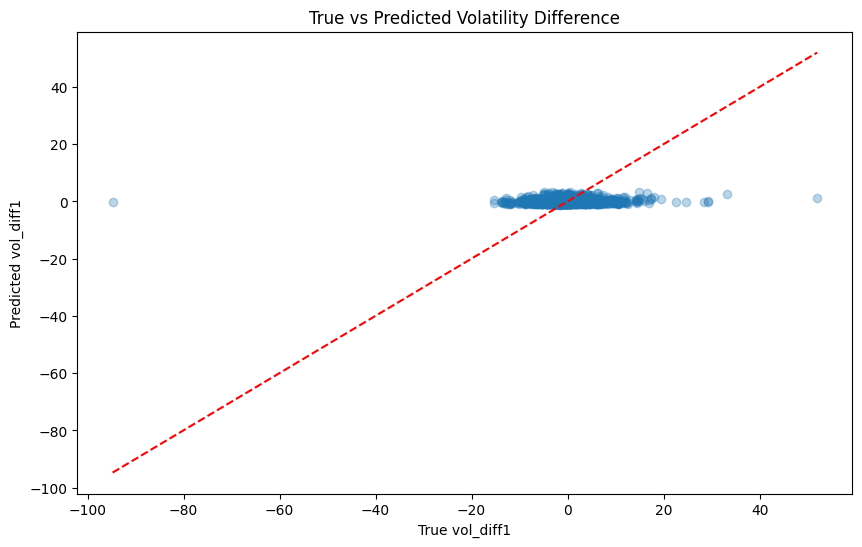

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

if df is not None:

   # ---------------------------------
   # 2. Generate Regression Predictions
   # ---------------------------------
   print("Running predictions on validation set...")
   # The regression model outputs a continuous value
   val_predictions = model.predict(X_val, batch_size=128, verbose=1)
   val_predictions = val_predictions.flatten()

   # ---------------------------------
   # 4. Final Evaluation Metrics
   # ---------------------------------
   mse = mean_squared_error(y_val, val_predictions)
   mae = mean_absolute_error(y_val, val_predictions)
   r2 = r2_score(y_val, val_predictions)

   print("\n--- Final Validation Performance Report ---")
   print(f"MSE: {mse:.4f}")
   print(f"MAE: {mae:.4f}")
   print(f"R2 Score: {r2:.4f}")

   # Plot
   plt.figure(figsize=(10, 6))
   plt.scatter(y_val, val_predictions, alpha=0.3)
   plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
   plt.xlabel("True vol_diff1")
   plt.ylabel("Predicted vol_diff1")
   plt.title("True vs Predicted Volatility Difference")
   plt.show()

else:
   print("Cannot evaluate: DataFrame was not loaded.")

# Embedding Extraction

In [ ]:
print("\n--- Creating Embedding Extraction Model ---")

# 1. Define input layers
input_ids_embed = tf_keras.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='input_ids_embed')
attention_mask_embed = tf_keras.Input(shape=(MAX_LENGTH,), dtype=tf.int32, name='attention_mask_embed')

# 2. Extract the fine-tuned TFBertModel layer from the already trained `model`
bert_layer = None
for layer in model.layers:
    if 'tf_bert_model' in layer.name:
        bert_layer = layer
        break

if bert_layer is None:
    raise ValueError("Could not find the TFBertModel layer in the trained model.")

# 3. Pass the defined input layers through the extracted bert_layer
embedding_output = bert_layer(input_ids=input_ids_embed, attention_mask=attention_mask_embed).pooler_output

# 4. Create a new tf_keras.models.Model named `embedding_model`
embedding_model = Model(
    inputs=[input_ids_embed, attention_mask_embed],
    outputs=embedding_output
)

print("Embedding extraction model created successfully.")
embedding_model.summary()

print("\n--- Extracting Embeddings ---")
# Extract embeddings for the training data
embeddings = embedding_model.predict(
    [X_train_no_val['input_ids'], X_train_no_val['attention_mask']],
    batch_size=batch_size
)

print(f"Extracted embeddings: {embeddings.shape}")

# --- Saving Embeddings ---
print("\n--- Saving Embeddings to NumPy files ---")

EMBEDDING_SAVE_DIR = os.path.join(BASE_DRIVE_PATH, 'embeddings')
os.makedirs(EMBEDDING_SAVE_DIR, exist_ok=True)

embeddings_path = os.path.join(EMBEDDING_SAVE_DIR, "embeddings_train.npy")
np.save(embeddings_path, embeddings)

print(f"Embeddings saved to: {embeddings_path}")

## Load embeddings

In [ ]:
loaded_embeddings = np.load(embeddings_path)

print("Embeddings loaded successfully!")
print(f"Shape for loaded_embeddings: {loaded_embeddings.shape}")

# Load & Re-evaluate

In [ ]:
# --- Loading the saved model with weight transfer ---
print("\n--- Loading the saved model via weight transfer ---")

try:
    # Instantiate the model with the same parameters
    fresh_regression_model = create_regression_model(MAX_LENGTH)

    # 2. Build tensors
    _ = fresh_regression_model(
        {
            'input_ids': X_val['input_ids'][:1],
            'attention_mask': X_val['attention_mask'][:1]
        }
    )
    print("Fresh model structure built.")

    # 3. Load the weights
    fresh_regression_model.load_weights(FULL_REGRESSION_SAVE_PATH)
    loaded_regression_model = fresh_regression_model
    print(f"Fine-tuned weights loaded successfully from: {FULL_REGRESSION_SAVE_PATH}")

except Exception as e:
    print(f"Error during weight loading: {e}")

# --- Re-evaluating with the loaded model ---
print("\n--- Re-evaluating with the loaded model ---")

if df is not None:
    print("Running predictions on validation set with loaded model...")
    loaded_val_predictions = loaded_regression_model.predict(X_val, batch_size=128, verbose=1)
    loaded_val_predictions = loaded_val_predictions.flatten()

    mse = mean_squared_error(y_val, loaded_val_predictions)
    print("\n--- Evaluation Report for Loaded Model ---")
    print(f"MSE: {mse:.4f}")

else:
    print("Cannot evaluate: DataFrame was not loaded.")